In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from classifiers.datasets.dataloader import Sklearn_DataLoader
from classifiers.datasets.datascaler import DataScaler
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from classifiers.callback import CostParamStorage
from classifiers.callback import SummaryWriter
from classifiers.quantum.quantum_circuits import AnsatzCircuit9

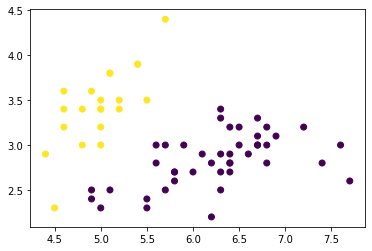

In [4]:
np.random.seed(0)
dl = Sklearn_DataLoader('iris', (0, 1, 2))
X, y, Xt, yt = dl(2**6, 0, True)
plt.scatter(X[:,0], X[:,1], c=y)
X = X[:, 0:2]
Xt = Xt[:, 0:2]
np.random.seed(None)

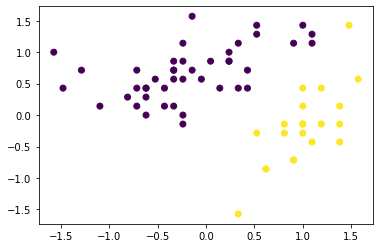

In [5]:
ds = DataScaler('minmax', feature_range=(-np.pi/2, np.pi/2))
X = -ds(X)
Xt = -ds(Xt)
plt.scatter(X[:,0], X[:,1], c=y)

In [21]:
kernel = Kernel('SingleQubit')
svm = BinarySVM(kernel, C=None, mutation='REDUCED_QASVM', k=1)
svm.fit(X, y)
svm.accuracy(Xt, yt)

0.8837209302325582

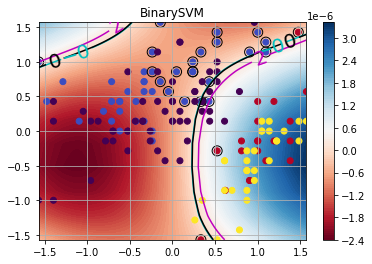

In [22]:
from classifiers.visualization import Plot_SVM
Plot_SVM(svm).plot_boundary()
plt.scatter(Xt[:,0], Xt[:,1], c=yt)

In [23]:
svm.f(Xt)

array([ 2.01359738e-06, -7.78766691e-07,  2.04903730e-06,  1.05043318e-07,
        1.15449219e-06,  1.24394730e-06,  2.68716228e-06, -8.35978418e-07,
       -2.32691291e-07, -1.74172906e-06, -1.97102601e-06,  2.58506339e-06,
       -1.37731046e-06,  2.12170495e-06, -4.13096086e-07,  4.64358434e-08,
       -8.89003707e-07,  2.73740022e-06,  1.05969787e-07, -6.57658889e-07,
       -1.29885818e-06, -1.88077848e-06, -1.11138460e-06, -6.57658889e-07,
        2.04748748e-07,  2.13061906e-06,  1.88744436e-06, -6.83511163e-07,
       -2.68834014e-07, -6.44535886e-07,  2.68716228e-06,  1.89578055e-06,
       -1.37731046e-06,  1.15449219e-06,  3.52889309e-07,  2.85437191e-06,
        2.20825364e-06, -1.01001731e-06, -1.20485838e-06, -2.25497463e-06,
       -1.98055224e-06, -1.26470203e-06,  1.88744436e-06, -4.69439514e-07,
       -6.57658889e-07, -6.57658889e-07,  1.39982235e-07,  4.50389367e-07,
        1.00288070e-06, -6.57658889e-07,  1.71056307e-06, -1.84673879e-06,
        7.51605417e-07, -

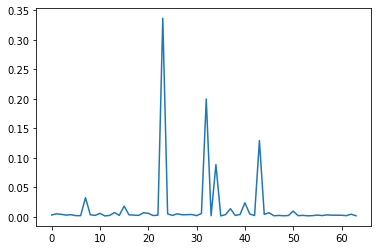

In [24]:
plt.plot(svm.alpha)

In [36]:
quantum_instance = QuantumInstance(AerSimulator(), shots=2**20, seed_simulator=0)
var_form = AnsatzCircuit9(6, reps=6)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, var_form=var_form, option='Bloch_sphere', C=None, k=0.001).dual
optimizer = SPSA(qasvm, blocking=True)

In [37]:
from tqdm.notebook import tqdm
storage = CostParamStorage()
writer = SummaryWriter()
last_avg=16
for t in tqdm(range(2**10)):
    optimizer.step(storage)
    writer.add_scalar('Cost', storage.last_avg(1, False)[0], t)
    if 2*storage.last_cost_std(last_avg, ignore_rejected=True) <= optimizer.allowed_increase and storage.num_accepted()>=last_avg:
        break

qasvm.parameters = storage.last_avg(last_avg, ignore_rejected=True)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [38]:
qasvm.accuracy(Xt, yt)

0.3372093023255814

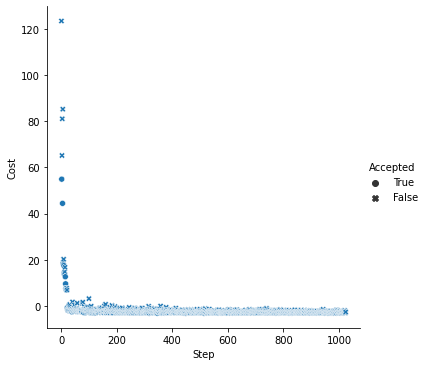

In [39]:
storage.plot()

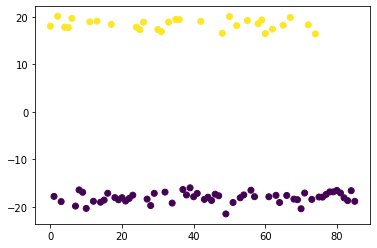

In [40]:
reg = np.array([qasvm.f(Xt) for _ in range(10)])
plt.errorbar(list(range(len(yt))), (2*yt-1)*reg.mean(axis=0), linestyle='none', yerr=2*reg.std(axis=0))
plt.scatter(list(range(len(yt))), (2*yt-1)*reg.mean(axis=0), marker='o', c=yt)

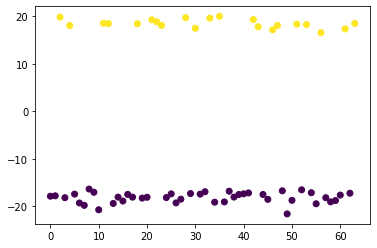

In [41]:
reg = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(list(range(len(y))), (2*y-1)*reg.mean(axis=0), linestyle='none', yerr=2*reg.std(axis=0))
plt.scatter(list(range(len(y))), (2*y-1)*reg.mean(axis=0), marker='o', c=y)

In [42]:
qasvm

Dual_QASVM (C=None, k=0.001)
Circuit Class: Bloch_sphere_QASVM_circuit
QuantumInstance: 
Qiskit Terra version: 0.17.2
Backend: 'aer_simulator (None)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'roerror', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector',

ValueError: array([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) is not a valid value for color

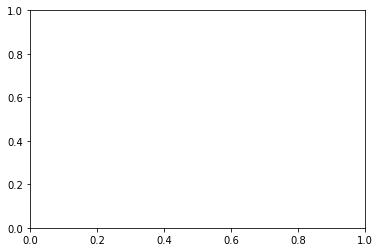

In [43]:
plt.plot(list(range(len(yt))), (2*yt-1)*svm.f(Xt), linestyle='none', marker='o', c=yt)

In [ ]:
svm.accuracy(Xt, yt)

In [ ]:
plt.plot(list(range(len(y))), (2*y-1)*svm.f(X), linestyle='none', marker='o', c=y)

In [ ]:
Plot_SVM(qasvm).plot_boundary()

In [ ]:
from classifiers.visualization import compare_svm_and_qasvm
svm.alpha = 1e7*svm.alpha
compare_svm_and_qasvm(svm, qasvm, 1)